#FULL CODE: Working with Yelp Review Text using NLTK

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
## Read in review data
## To get the full dataset, use the below: 
rvws = pd.read_csv("data\yelp_academic_dataset_review.csv")

## Below csv was created previously using the first 5,000 reviews. Once this is a working model we can expand it to a fuller dataset.
# reviews = pd.read_csv("data\yelp_academic_dataset_review.csv")
# rvws = reviews.iloc[:5000,:]
# rvws.to_csv("yelp_dataset_testing.csv")
# rvws = pd.read_csv("data\yelp_dataset_5k_review.csv")

In [3]:
## To make things easier when trying to analyze the text, let's just look at restaurants. For that, we'll have to join the review
## and business data. I'm also pulling the city and state so we can split this up by city, based on the assumption that
## language will vary depending on location.

headers = ['categories','business_id','city','state']
business = pd.read_csv("data\yelp_academic_dataset_business.csv", usecols = headers)
reviews_full = pd.merge(rvws, business, on = 'business_id')

In [4]:
## Now that we have the data joined with the business information, we can narrow the dataset to just restaurants so that
## the language we are looking for is more consistent. 
## (e.g. a good doctor review will have differnt language than a good restaurant review)

cat = reviews_full['categories']
rest = []

for x in range(len(cat)):
    if "Restaurants" in cat[x]:
        rest.append(1)
    elif "Food" in cat[x]:
        rest.append(1)
    else:
        rest.append(0)

reviews_full['restaurant'] = rest

## This will modify our reviews DataFrame to only include business that fall into the "restaurants" category,
## Then reset the index.

reviews_full = reviews_full[reviews_full['restaurant'] == 1]
reviews_full = reviews_full.reset_index(drop=True)

In [5]:
## In addition to narrowing it down to one city to work with. We will revisit the impact of location after doing as much
## as we can with just the text for all reviews in one city.

city = reviews_full['city']
city.value_counts()[:30]

Las Vegas          402889
Phoenix            156592
Scottsdale          85399
Charlotte           67038
Pittsburgh          50538
Tempe               47012
Henderson           32641
Chandler            30578
Madison             29697
Mesa                27842
Montréal            23631
Gilbert             19281
Glendale            16960
Edinburgh           13999
Montreal            12746
Peoria               8209
Champaign            6772
North Las Vegas      6458
Surprise             5283
Goodyear             4891
Avondale             3560
Queen Creek          3042
Cave Creek           2994
Urbana               2826
Matthews             2587
Middleton            1978
Karlsruhe            1710
Fort Mill            1656
Waterloo             1480
Concord              1333
dtype: int64

In [7]:
## To lower run time and make the featureset more consistent, limit to one city.

reviews = reviews_full[reviews_full['city'] == 'Avondale']
reviews = reviews.reset_index(drop=True)
reviews.to_csv("yelp_dataset_reviews_Avondale")
reviews.head()

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful,categories,state,city,restaurant
0,cTT7cTG6SuVOc1ib6gwhHA,uPez-RSvBOxO1AWTGMtB7g,3.5 Stars\n\nEvery clerk there is friendly. N...,2,j5qC_y7mRRWNUqFdR8Z1_A,1,3,2013-10-13,review,3,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1
1,kcgYbndUk0e07YusRAcTrg,Q6L6oNvb60GMqdN5xxSRiw,"Simple and small, haven't tried their water or...",0,j5qC_y7mRRWNUqFdR8Z1_A,0,3,2014-07-29,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1
2,vrIuFfhpUyOA_m9goXVWxw,yVV5W3cDRYow2nEPQDN-EQ,Ashley is really awesome she is always with a ...,0,j5qC_y7mRRWNUqFdR8Z1_A,1,5,2014-10-01,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1
3,l72Kt2u68aLuJVX9J8J0hQ,PLEltvCMh8u7FlxFf225og,Great old time ice cream shop from the '20s. R...,0,j5qC_y7mRRWNUqFdR8Z1_A,0,5,2014-10-04,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1
4,Iqw0kVKBtgo4Vn8AtG2kRA,BuwZ9XJgenH9mET_zCCbrA,This is a small family owned business so I'll ...,0,j5qC_y7mRRWNUqFdR8Z1_A,0,3,2014-11-16,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1


Value counts for each star so we can get a general sense of distribution:
5    1260
4    1097
3     488
1     393
2     322
dtype: int64


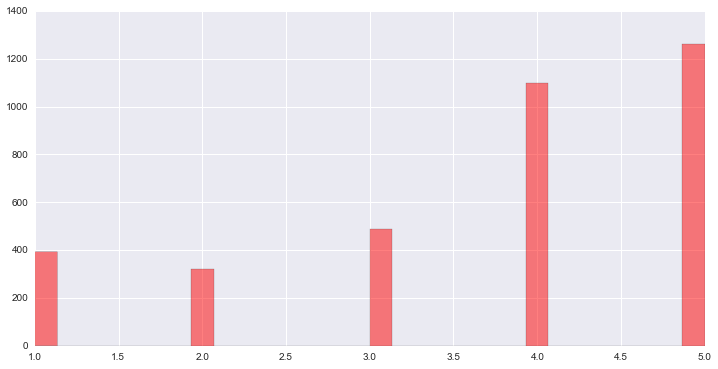

In [8]:
## Separate into features and target

text = reviews['text']
stars = reviews['stars']

print "Value counts for each star so we can get a general sense of distribution:"
print stars.value_counts()
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
stars.hist(color='red', alpha=0.5, bins = 30)

In [9]:
## Create features based on the text.
## First, append text_length to data frame which signifies the length of the review text.

text_length = []
for x in range(len(reviews['text'])):
    text_length.append(len(text[x]))

reviews['text_length'] = text_length
reviews.head()

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful,categories,state,city,restaurant,text_length
0,cTT7cTG6SuVOc1ib6gwhHA,uPez-RSvBOxO1AWTGMtB7g,3.5 Stars\n\nEvery clerk there is friendly. N...,2,j5qC_y7mRRWNUqFdR8Z1_A,1,3,2013-10-13,review,3,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1,616
1,kcgYbndUk0e07YusRAcTrg,Q6L6oNvb60GMqdN5xxSRiw,"Simple and small, haven't tried their water or...",0,j5qC_y7mRRWNUqFdR8Z1_A,0,3,2014-07-29,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1,722
2,vrIuFfhpUyOA_m9goXVWxw,yVV5W3cDRYow2nEPQDN-EQ,Ashley is really awesome she is always with a ...,0,j5qC_y7mRRWNUqFdR8Z1_A,1,5,2014-10-01,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1,196
3,l72Kt2u68aLuJVX9J8J0hQ,PLEltvCMh8u7FlxFf225og,Great old time ice cream shop from the '20s. R...,0,j5qC_y7mRRWNUqFdR8Z1_A,0,5,2014-10-04,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1,278
4,Iqw0kVKBtgo4Vn8AtG2kRA,BuwZ9XJgenH9mET_zCCbrA,This is a small family owned business so I'll ...,0,j5qC_y7mRRWNUqFdR8Z1_A,0,3,2014-11-16,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1,1167


In [11]:
## Download list of positive / negative from here: http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html
## Grab a generic words of positive and negative words; we are going to use these to get a sentiment score out of the text.

positives = open('data/positive-words.txt').read()
negatives = open('data/negative-words.txt').read()
pos_word_list = positives.split('\n')
neg_word_list = negatives.split('\n')
print "POSITIVE WORDS: {}".format(pos_word_list)
print "NEGATIVE WORDS: {}".format(neg_word_list)

POSITIVE WORDS: ['', '', 'a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade', 'accolades', 'accommodative', 'accomodative', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'accurate', 'accurately', 'achievable', 'achievement', 'achievements', 'achievible', 'acumen', 'adaptable', 'adaptive', 'adequate', 'adjustable', 'admirable', 'admirably', 'admiration', 'admire', 'admirer', 'admiring', 'admiringly', 'adorable', 'adore', 'adored', 'adorer', 'adoring', 'adoringly', 'adroit', 'adroitly', 'adulate', 'adulation', 'adulatory', 'advanced', 'advantage', 'advantageous', 'advantageously', 'advantages', 'adventuresome', 'adventurous', 'advocate', 'advocated', 'advocates', 'affability', 'affable', 'affably', 'affectation', 'affection', 'affectionate', 'affinity', 'affirm', 'affirmation', 'affirmative', 'affluence', 'affluent', 'afford', 'affordable', 'affordably', 'afordable', 'agile', 'agilely', 'ag

In [12]:
## Create function to output list of words in given list from a sentence.
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def review_to_wordlist(review, remove_stopwords=False):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.

    review_text = review   
    
    # 1. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)

    # 2. Convert words to lower case and split them
    words = review_text.lower().split()

    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    # 5. Return a list of words
    return(words)

def word_count(sentence, word_list):
    count = 0
    for x in review_to_wordlist(sentence):
        if x in word_list:
            count += 1
    
    return count

In [14]:
%%time

## Use positive and negative words to give each piece of a text a sentiment score. The sentiment score ranges from
## -1 (all negative words) to 1 (all positive words).

sentiment = []
pos_neg_ratio = []
count = 0

for x in text:
    positive = word_count(x, pos_word_list)
    negative = word_count(x, neg_word_list)
    if (negative > 0):
        ratio = float(positive)/negative
    else:
        ratio = positive
    
    if ((positive + negative) == 0):
        sent = 1
    else:
        sent = ((positive-negative)/(float(positive)+negative))+1
        
    sentiment.append(sent)
    pos_neg_ratio.append(ratio)
    if count % 1000 == 0:
        print "Scoring text #{}".format(count)
    count += 1

reviews['sentiment'] = sentiment
reviews['pos_neg_ratio'] = pos_neg_ratio

Scoring text #0
Scoring text #1000
Scoring text #2000
Scoring text #3000
Wall time: 40.5 s


In [15]:
## Features used for initial pass: text length, ratio of positive to negative words, and sentiment.

feature_list = ['text_length', 'pos_neg_ratio', 'sentiment']
features = reviews[feature_list]
stars = reviews['stars']

In [16]:
## Test using Various models. Set up the train test split first, then fit various models and see how they perform.

from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score

In [17]:
## Fit various models

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = cross_validation.train_test_split(features, stars, test_size=0.3, random_state=12)
forest = RandomForestClassifier()
mnbayes = MultinomialNB()
linearSVC = LinearSVC()
adaboost = AdaBoostClassifier()
logreg = LogisticRegression()

forest.fit(x_train, y_train)
mnbayes.fit(x_train, y_train)
linearSVC.fit(x_train, y_train)
adaboost.fit(x_train, y_train)
logreg.fit(x_train, y_train)

print "Random Forest score: {}".format(forest.score(x_test, y_test))
print "Multinomial Naive Bayes score: {}".format(mnbayes.score(x_test, y_test))
print "Linear SVC Score: {}".format(linearSVC.score(x_test, y_test))
print "Ada Boosted Decision Tree Score: {}".format(adaboost.score(x_test, y_test))
print "Logistic Regression Score: {}".format(logreg.score(x_test, y_test))

Random Forest score: 0.35861423221
Multinomial Naive Bayes score: 0.424157303371
Linear SVC Score: 0.383895131086
Ada Boosted Decision Tree Score: 0.420411985019
Logistic Regression Score: 0.453183520599


In [18]:
## Before trying to move on to a new method, let's make this a binary predictor by
## separating reviews into "good" (4-5 stars) and "bad" (1-3 stars)

# Playing with different star thresholds for what we consider a "good" or "bad" review.
star_threshold = 4

reviews['good'] = (reviews['stars'] >= star_threshold)
good = reviews['good']
good = good.map({True: 1, False: 0})

In [19]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(features, good, test_size=0.3, random_state=12)

forest.fit(x_train, y_train)
mnbayes.fit(x_train, y_train)
linearSVC.fit(x_train, y_train)
adaboost.fit(x_train, y_train)
logreg.fit(x_train, y_train)

print "Random Forest score: {}".format(forest.score(x_test, y_test))
print "Multinomial Naive Bayes score: {}".format(mnbayes.score(x_test, y_test))
print "Linear SVC Score: {}".format(linearSVC.score(x_test, y_test))
print "Ada Boosted Decision Tree Score: {}".format(adaboost.score(x_test, y_test))
print "Logistic Regression Score: {}\n \n".format(logreg.score(x_test, y_test))

print "Random Forest AUC: {}".format(cross_val_score(forest, features, good, cv=3, scoring='roc_auc').mean())
print "Multinomial Naive Bayes AUC: {}".format(cross_val_score(mnbayes, features, good, cv=3, scoring='roc_auc').mean())
print "Linear SVC AUC: {}".format(cross_val_score(linearSVC, features, good, cv=3, scoring='roc_auc').mean())
print "Ada Boosted Decision Tree AUC: {}".format(cross_val_score(adaboost, features, good, cv=3, scoring='roc_auc').mean())
print "Logistic Regression AUC: {}".format(cross_val_score(logreg, features, good, cv=3, scoring='roc_auc').mean())

Random Forest score: 0.708801498127
Multinomial Naive Bayes score: 0.756554307116
Linear SVC Score: 0.668539325843
Ada Boosted Decision Tree Score: 0.772471910112
Logistic Regression Score: 0.7734082397
 

Random Forest AUC: 0.735184142877
Multinomial Naive Bayes AUC: 0.785258161787
Linear SVC AUC: 0.681664862791
Ada Boosted Decision Tree AUC: 0.801001525025
Logistic Regression AUC: 0.812701576286


##Adjust "good" and "bad" word list by taking a look at the text data

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

vect = CountVectorizer(decode_error = 'ignore', stop_words = 'english', min_df=0.005)
vect.fit(text)
text_dtm = vect.transform(text)
text_array = text_dtm.toarray()

count_vocab = np.sum(text_array, axis=0)
vocab_list = vect.get_feature_names()
vocab_freq_df = pd.DataFrame({'Frequency': count_vocab, 'Token': vocab_list})
print "Words in feature set: {}".format(len(vect.get_feature_names()))
print vocab_freq_df.sort(columns = 'Frequency', ascending = False)

Words in feature set: 1225
      Frequency        Token
415        2880         food
459        2352         good
801        2003        place
469        1401        great
600        1339         like
945        1203      service
568        1150         just
1086       1033         time
171         938      chicken
861         806       really
631         695         love
746         682        order
747         668      ordered
1143        657           ve
462         651          got
1120        619          try
429         609     friendly
880         601   restaurant
710         599         nice
315         594          don
84          588         best
282         572    delicious
610         555       little
424         537        fresh
431         534        fries
887         498         rice
1014        495        staff
1184        460         went
124         453       burger
140         447         came
...         ...          ...
368          19  experiences
836          19 

In [23]:
test_sent = ['this','is','a','good','service','test']
test_sent[test_sent.index('test')-1]

'service'

##Let's work with the text, then vectorize the text and fit it to that.

In [68]:
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words("english"))
# from nltk.stem.wordnet import WordNetLemmatizer
# le = WordNetLemmatizer()
# asdf = ['cat','cats','catting','about','pooping','poop','poops','a','pooper','be']
# for x in asdf:
#     print le.lemmatize(x)
# asdf = [le.lemmatize(z) for z in asdf if not z in stop_words]
# asdf

In [23]:
%%time

## We're going to get rid of stop words and non-letters.
## We're also going to run the text through a lemmatizer, which will help narrow down the feature set.
## This will take some time.

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

stop_words = set(stopwords.words("english"))
count = 0
text_clean = text
lemm = WordNetLemmatizer()

## Before cleaning the text, we'll vectorize the uncleaned text to see how the difference it makes.
vect = CountVectorizer(decode_error = 'ignore')
vect.fit(text_clean)
dirty_text_length = len(vect.vocabulary_)

for x in range(len(text_clean)):
    count +=1
    if count % 1000 == 0:
        print "Cleaning text #{}...".format(count)
    w = text[x]
    w = re.sub("[^a-zA-Z]"," ", w)    # gets rid of non-letters and substitutes it with a space
    w = word_tokenize(w)    # Tokenizes the sentence, breaking it up into a list of words rather than one long string.
    w = [lemm.lemmatize(z) for z in w if not z in stop_words]    # deletes stop words from the text, or words that don't add any meaning
    text_clean[x] = w

text_clean = [' , '.join(z).strip() for z in text_clean]

Cleaning text #1000...
Cleaning text #2000...
Cleaning text #3000...
Wall time: 9min 28s


C:\Users\samchu\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
## Fit it to a regular count vectorizor so we can compare the unprocessed vs. processed text.

vect = CountVectorizer(decode_error = 'ignore')
vect.fit(text_clean)
clean_text_length = len(vect.vocabulary_)
print "Text without any edits had {} unique tokens.".format(dirty_text_length)
print "Text after removing stop words and lemmatizing, the text had {} unique tokens.".format(clean_text_length)

## Vectorize the text with sklearn's TfidfVectorizer... This weights each word depending on the Tf-idf importance.

vect = TfidfVectorizer(stop_words='english', ngram_range = (1,1), decode_error = 'ignore')
vect.fit(text_clean)

## Map the vectorized text to an array and Pandas dataframe

text_dtm = vect.transform(text_clean)
text_array = text_dtm.toarray()
text_df = pd.DataFrame(text_array, columns = vect.get_feature_names())

In [ ]:
## Fit and score on the vectorized clean text.

x_train, x_test, y_train, y_test = cross_validation.train_test_split(text_array, stars, test_size=0.3, random_state=12)

forest.fit(x_train, y_train)
mnbayes.fit(x_train, y_train)
linearSVC.fit(x_train, y_train)
adaboost.fit(x_train, y_train)
logreg.fit(x_train, y_train)

print "Random Forest score: {}".format(forest.score(x_test, y_test))
print "Multinomial Naive Bayes score: {}".format(mnbayes.score(x_test, y_test))
print "Linear SVC Score: {}".format(linearSVC.score(x_test, y_test))
print "Ada Boosted Decision Tree Score: {}".format(adaboost.score(x_test, y_test))
print "Logistic Regression Score: {}\n \n".format(logreg.score(x_test, y_test))

Random Forest score: 0.40074906367
Multinomial Naive Bayes score: 0.412921348315
Linear SVC Score: 0.425093632959
Ada Boosted Decision Tree Score: 0.356741573034
Logistic Regression Score: 0.414794007491
 



Per the above results, this performed slightly better than the model generated with the sentiment score, positive/negative ratio and length of text. Multinomial Naive Bayes performed the best so far as well.

In [27]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(text_array, good, test_size=0.3, random_state=12)

forest.fit(x_train, y_train)
mnbayes.fit(x_train, y_train)
linearSVC.fit(x_train, y_train)
adaboost.fit(x_train, y_train)
logreg.fit(x_train, y_train)

print "Random Forest score: {}".format(forest.score(x_test, y_test))
print "Multinomial Naive Bayes score: {}".format(mnbayes.score(x_test, y_test))
print "Linear SVC Score: {}".format(linearSVC.score(x_test, y_test))
print "Ada Boosted Decision Tree Score: {}".format(adaboost.score(x_test, y_test))
print "Logistic Regression Score: {}\n".format(logreg.score(x_test, y_test))

print "Random Forest AUC: {}".format(cross_val_score(forest, features, good, cv=3, scoring='roc_auc').mean())
print "Multinomial Naive Bayes AUC: {}".format(cross_val_score(mnbayes, features, good, cv=3, scoring='roc_auc').mean())
print "Linear SVC AUC: {}".format(cross_val_score(linearSVC, features, good, cv=3, scoring='roc_auc').mean())
print "Ada Boosted Decision Tree AUC: {}".format(cross_val_score(adaboost, features, good, cv=3, scoring='roc_auc').mean())
print "Logistic Regression AUC: {}".format(cross_val_score(logreg, features, good, cv=3, scoring='roc_auc').mean())

Random Forest score: 0.787453183521
Multinomial Naive Bayes score: 0.723782771536
Linear SVC Score: 0.847378277154
Ada Boosted Decision Tree Score: 0.814606741573
Logistic Regression Score: 0.828651685393

Random Forest AUC: 0.734864644949
Multinomial Naive Bayes AUC: 0.785258161787
Linear SVC AUC: 0.634453789919
Ada Boosted Decision Tree AUC: 0.801001525025
Logistic Regression AUC: 0.812701576286


### Using the vectorization of the words, we get a respectable AUC for MN Bayes when testing for good / bad reviews. Let's continue to try to improve this.

#####Let's create a voting classifier that takes votes from 5 different classifiers and returns the most popular vote. We'll use an AdaBoosted Decision Tree, Random Forests, Multinomial Naive Bayes, Linear SVC and Logistic Regression.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = cross_validation.train_test_split(features, stars, test_size=0.3, random_state=12)
forest = RandomForestClassifier()
mnbayes = MultinomialNB()
linearSVC = LinearSVC()
adaboost = AdaBoostClassifier()
logreg = LogisticRegression()

## Create a list that contains five classifiers, then fit them.
voter = [forest, mnbayes, linearSVC, adaboost, logreg]
for x in voter:
    x.fit(x_train, y_train)

number_votes = len(voter)

## Put the predictions of all five classifiers into another array.
votes = []
for x in voter:
    votes.append(x.predict(x_test))

## Put all predictions into a list of votes
all_votes = []
for y in votes:
    for x in y:
        